In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re
from nltk.stem.porter import PorterStemmer

df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")

ps = PorterStemmer()
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been',
             'before','being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do','does', 'doing', 'down', 'during', 'each','few',
             'for', 'from','further', 'had', 'has', 'have', 'having', 'he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was','we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre","youve", 'your', 'yours', 'yourself', 'yourselves']

def preprocess(text):
    cleaned_text = re.sub(r"http\S+", "", text)
    cleaned_text = re.sub(r"<[^>]*>", "", cleaned_text)
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)
    cleaned_text = re.sub(r"(.)\1{2,}", r"\1", cleaned_text)
    cleaned_text = re.sub(r"\d", "", cleaned_text)
    cleaned_text = " ".join([word for word in cleaned_text.split() if word.lower() not in stopwords])

    stemmed_words = [ps.stem(word) for word in cleaned_text.split()]
    cleaned_text = " ".join(stemmed_words)
    return cleaned_text

df["text"].apply(preprocess)

0       car car around sinc becam famou henri ford cre...
1       transport larg necess countri worldwid no doub...
2       america love affair vehicl seem cool say elisa...
3       often ride car drive one motor vehicl work sto...
4       car wonder thing perhap one world greatest adv...
                              ...                        
1373    fuss elector colleg mani peopl get confus work...
1374    limit car usag mani advantag put lot less poll...
1375    there new trend develop year soon full throttl...
1376    know car big part societi today howev car bigg...
1377    car around sinc popular ever sinc although rec...
Name: text, Length: 1378, dtype: object

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer()
x = vector.fit_transform(df["text"])
y = df["generated"]
x.shape, y.shape

((1378, 16355), (1378,))

In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=32)

[Voting] ...................... (1 of 6) Processing mnb, total=   0.0s
[Voting] ....................... (2 of 6) Processing rf, total=   0.4s
[Voting] ....................... (3 of 6) Processing dt, total=   0.1s
[Voting] ....................... (4 of 6) Processing sv, total=   0.5s
[Voting] ....................... (5 of 6) Processing lr, total=   0.4s
[Voting] ...................... (6 of 6) Processing xgb, total=   3.4s
Accuracy 0.9927536231884058 
Precision 0.0 
Recall 0.0 
Classification Report               precision    recall  f1-score   support

           0       0.99      1.00      1.00       137
           1       0.00      0.00      0.00         1

    accuracy                           0.99       138
   macro avg       0.50      0.50      0.50       138
weighted avg       0.99      0.99      0.99       138



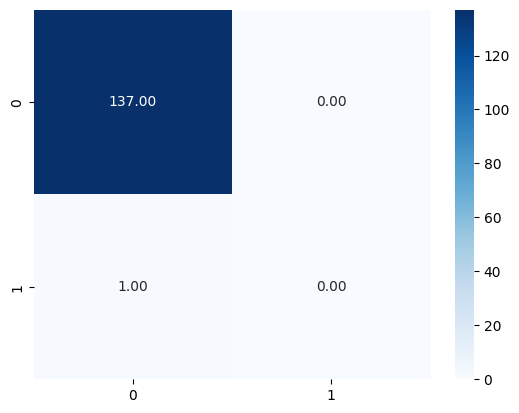

In [4]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class MyModel:
    def __init__(self):
        self.MNB = MultinomialNB()
        self.RFC = RandomForestClassifier()
        self.DT = DecisionTreeClassifier()
        self.SVM = SVC()
        self.LR = LogisticRegression()
        self.XGB = XGBRFClassifier()
        self.voting_model = VotingClassifier(
            estimators=[("mnb", self.MNB), 
                        ("rf", self.RFC), 
                        ("dt", self.DT), 
                        ("sv", self.SVM), 
                        ("lr", self.LR), 
                        ("xgb", self.XGB)],
            voting="hard",
            verbose=True)

    def train(self, x_train, y_train):
        self.voting_model.fit(x_train, y_train)
        
    def predict(self, test_data):
        return self.voting_model.predict(test_data)
    
    def evaluate(self, test_data):
        y_pred = self.voting_model.predict(test_data)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        clf_report = classification_report(y_test, y_pred)
        print(f"Accuracy {accuracy} \nPrecision {precision} \nRecall {recall} \nClassification Report {clf_report}")
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, cmap="Blues",  fmt='.2f')
        plt.plot()
    
voting_model = MyModel()
voting_model.train(x_train, y_train)
voting_model.evaluate(x_test)

In [5]:
test_ds = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_ds.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [6]:
test_ds["text"].apply(preprocess)
test_x = vector.transform(test_ds["text"])
y_pred = voting_model.predict(test_x)

In [7]:
submission = pd.DataFrame({'id':test_ds['id'],'generated':y_pred})
submission.head()

,id,generated
0,0000aaaa,0
1,1111bbbb,0
2,2222cccc,0


In [8]:
submission.to_csv('submission.csv',index=False)